# Combined Notebook: Optimization Project 1

- Archie Korale Arachchige Don (abk844)
- Darius Hajibashi (dph865)
- Rizvee Ahmed (ra44349)
- Zan Merrill (ahm2452)


## Setup

In [1]:
# uncomment this if you want to run in colab
# note: this may not run the full version of gurobi that we have
# better to download the file, edit, then re-upload

!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 44.7 MB/s eta 0:00:00


In [2]:
# load dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import linprog
import gurobipy as gp
from gurobipy import GRB, Model, quicksum
import seaborn as sns


In [3]:
# Set paths
# Note: This controls all other paths in the notebook
path_2019 = "https://raw.githubusercontent.com/AHMerrill/optimization_1/main/stocks2019.csv"
path_2020 = "https://raw.githubusercontent.com/AHMerrill/optimization_1/main/stocks2020.csv"

# Parts 1–2

# CVaR Portfolio Optimization

The goal of this project is to build a **long-only equity portfolio** that **minimizes Conditional Value-at-Risk (CVaR)** at level Beta. To train the portfolio on **2019** daily returns, then **evaluate** the same allocation on **2020**, and compare to a benchmark (**NDX**) as a single-asset portfolio.

In [4]:
# load for parts 1 & 2

def _parse_index_dates(df: pd.DataFrame) -> pd.DataFrame:
    # look at a sample non-null index value as a string
    sample = next((str(s) for s in df.index if pd.notna(s)), "")
    # crude format sniffing
    if "-" in sample and len(sample.split("-")[0]) == 4:
        fmt = "%Y-%m-%d"    # e.g., 2019-01-02
    elif "/" in sample:
        # Likely M/D/YY or MM/DD/YY
        fmt = "%m/%d/%y"    # e.g., 1/2/20 or 01/02/20
    else:
        fmt = "mixed"       # let pandas infer per-element

    df.index = pd.to_datetime(df.index, format=fmt)
    return df

# --- load using your paths and parse dates reliably ---
prices_2019 = pd.read_csv(path_2019, index_col=0)
prices_2019 = _parse_index_dates(prices_2019)

prices_2020 = pd.read_csv(path_2020, index_col=0)
prices_2020 = _parse_index_dates(prices_2020)


In [5]:
prices_2019[:3]

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715


In [6]:
prices_2020[:3]

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
2020-01-02,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,231.917572,...,36.970001,254.550003,196.729996,150.167465,219.449997,56.046688,167.460007,64.771545,60.782249,100.115349
2020-01-03,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,230.343124,...,36.180000,250.169998,200.880005,151.628220,217.979996,56.046688,168.440002,63.774597,61.074562,97.810677
2020-01-06,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,232.110748,...,35.689999,250.949997,202.740005,151.976013,224.029999,56.530506,169.490005,62.550629,60.986866,95.771927


## Convert prices --> returns & define the investable universe

**Goal**
- Convert daily prices to **arithmetic daily returns**
- Keep 'NDX' aside as a **benchmark** and **exclude it** from investable assets
- Keep only tickers present in **BOTH** years to be robust to missing names/delistings

In [7]:
# convert prices to arithmetic daily returns and drop the initial NaNs
rets_2019_all = prices_2019.pct_change().dropna(how = "all")
rets_2020_all = prices_2020.pct_change().dropna(how = "all")

# separate benchmark series; exclude it from investable universe
index_col = "NDX"
if index_col not in rets_2019_all or index_col not in rets_2020_all:
    raise ValueError(f"expected benchmark column '{index_col}' missing from csvs")

ndx_2019 = rets_2019_all[index_col].dropna()
ndx_2020 = rets_2020_all[index_col].dropna()

# investable = everything except the index column
inv_2019 = rets_2019_all.drop(columns = [index_col]).dropna(axis = 1, how = "any")
inv_2020 = rets_2020_all.drop(columns = [index_col]).dropna(axis = 1, how = "any")

# align the investable tickers across years (intersection)
common_cols = sorted(set(inv_2019.columns) & set(inv_2020.columns))
if len(common_cols) == 0:
    raise ValueError("no common investable tickers across 2019 and 2020")

rets_2019 = inv_2019[common_cols].dropna()
rets_2020 = inv_2020[common_cols].dropna()

# small helper to print percents nicely
def as_pct(x):
    return 100.0 * float(x)

We want a **long-only** portfolio that minimizes tail risk measured by **CVar** at level Beta. CVaR is the **average loss** in the worst (1-Beta) fraction of days.
Daily **loss** on day \(k\) for weights \(x\) and returns \(y_k\): \(L_k = -x^\top y_k\).
- Decision variables: \(x\) (weights), \(\alpha\) (VaR threshold), \(u_k\) (tail slacks).

**Linear Program (Rockafellar–Uryasev):**


## Solve for the weights on the 2019 training sample

Optimize x to minimize Beta-CVaR on 2019 with a long-only budget and daily expected return floor, R.  
We’ll return the weights, VaR (alpha), and CVaR (objective value).

In [8]:
def solve_cvar_min_long_only(returns_df, beta=0.95, min_return=0.0002, quiet=True):
    """
    minimize beta-CVaR of daily losses (Rockafellar-Uryasev LP) on a training sample.

    returns:
        dict with:
          - 'x': pd.Series of optimal weights (sorted descending)
          - 'VaR': optimal alpha (daily VaR at level beta)
          - 'CVaR': optimal objective value (daily CVaR at level beta)
          - 'model': gurobi model (if you want diagnostics)
    """
    # matrices
    Y = returns_df.values              # shape: q x n (rows: days, cols: assets)
    q, n = Y.shape
    mu = returns_df.mean(axis = 0).values  # mean daily returns per asset

    # build model
    m = Model("min_cvar")
    if quiet:
        m.Params.OutputFlag = 0  # silence solver log

    # decision variables
    x = m.addVars(n, lb = 0.0, name = "x")                 # long-only weights
    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")   # VaR threshold
    u = m.addVars(q, lb = 0.0, name = "u")                 # tail slack variables

    # VaR + average tail loss --> the objective
    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    # tail constraints: u_k >= -x^T y_k - alpha  (excess loss above VaR)
    for k in range(q):
        m.addConstr(u[k] >= -quicksum(Y[k, j] * x[j] for j in range(n)) - alpha, name = f"tail_{k}")

    # fully invested, long-only
    m.addConstr(quicksum(x[j] for j in range(n)) == 1.0, name = "budget")

    # small daily expected return floor
    m.addConstr(quicksum(mu[j] * x[j] for j in range(n)) >= min_return, name = "min_return")

    # optimize
    m.optimize()

    # collect solution
    x_series = pd.Series([x[j].X for j in range(n)], index = returns_df.columns, name = "weight")
    x_series = x_series.sort_values(ascending = False)
    return {"x": x_series, "VaR": alpha.X, "CVaR": m.objVal, "model": m}


## Re-evaluate CVaR on new data for a fixed portfolio

Hold x fixed (from 2019) and compute VaR/CVaR on 2020 by optimizing only alpha and u. This isolates out-of-sample risk for the same allocation

In [9]:
def evaluate_cvar_fixed_weights(returns_df, weights, beta = 0.95, quiet = True):

    # align weights to columns
    w = weights.reindex(returns_df.columns).fillna(0.0).values
    Y = returns_df.values
    q, n = Y.shape

    # daily portfolio losses for the fixed weights
    losses = -Y.dot(w)

    # build eval model
    m = Model("eval_cvar_fixed_x")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")
    u = m.addVars(q, lb = 0.0, name = "u")

    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    # tail constraints for the realized losses
    for k in range(q):
        m.addConstr(u[k] >= float(losses[k]) - alpha, name = f"tail_eval_{k}")

    m.optimize()
    return {"VaR": alpha.X, "CVaR": m.objVal}

## Compute benchmark CVaR for single series (NDX)

Treat NDX like a one-asset portfolio with weight 1. Compute its VaR/CVaR on each year

In [10]:
def evaluate_cvar_single_series(series_returns, beta = 0.95, quiet = True):

    losses = -series_returns.dropna().values  # loss = -return
    q = losses.shape[0]

    m = Model("eval_cvar_single")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb = -GRB.INFINITY, name = "alpha")
    u = m.addVars(q, lb = 0.0, name = "u")

    inv_tail_mass = 1.0 / ((1.0 - beta) * q)
    m.setObjective(alpha + inv_tail_mass * quicksum(u[k] for k in range(q)), GRB.MINIMIZE)

    for k in range(q):
        m.addConstr(u[k] >= float(losses[k]) - alpha, name=f"tail_single_{k}")

    m.optimize()
    return {"VaR": alpha.X, "CVaR": m.objVal}

## Run experiment (Beta = 0.95)
- Train on 2019 with Beta = 0.95 and R = 0.02% daily
- Report in-sample (2019) and out-of-sample (2020) VaR/CVaR
- Compare with NDX for both years
- Print top weights

In [11]:
beta_values   = [0.95]   # later: [0.90, 0.95, 0.99] for sensitivity analysis
min_daily_ret = 0.0002   # 0.02% minimum expected daily return

experiment_out = []
for beta in beta_values:
    # 1) train: learn weights on 2019
    train = solve_cvar_min_long_only(rets_2019, beta = beta, min_return = min_daily_ret, quiet = True)
    w_star = train["x"]

    # 2) evaluate: fixed weights on 2019 (in-sample) and 2020 (out-of-sample)
    ins = evaluate_cvar_fixed_weights(rets_2019, w_star, beta = beta, quiet = True)
    oos = evaluate_cvar_fixed_weights(rets_2020, w_star, beta = beta, quiet = True)

    # 3) benchmark: NDX alone in both periods
    ndx_2019_stats = evaluate_cvar_single_series(ndx_2019, beta = beta, quiet = True)
    ndx_2020_stats = evaluate_cvar_single_series(ndx_2020, beta = beta, quiet = True)

    print(f"\n=== beta = {beta:.2f} ===")
    print(f"in-sample  (2019)  VaR = {as_pct(ins['VaR']):.4f}%   CVaR = {as_pct(ins['CVaR']):.4f}%")
    print(f"out-of-sample(2020) VaR = {as_pct(oos['VaR']):.4f}%   CVaR = {as_pct(oos['CVaR']):.4f}%")
    print(f"NDX 2019            VaR = {as_pct(ndx_2019_stats['VaR']):.4f}%   CVaR = {as_pct(ndx_2019_stats['CVaR']):.4f}%")
    print(f"NDX 2020            VaR = {as_pct(ndx_2020_stats['VaR']):.4f}%   CVaR = {as_pct(ndx_2020_stats['CVaR']):.4f}%")

    # show top allocations for interpretability
    top5 = w_star.head(5)
    print("\nTop-5 weights:")
    for t, w in top5.items():
        print(f"  {t:<10s} {as_pct(w):6.2f}%")

    experiment_out.append({
        "beta": beta,
        "weights": w_star,
        "ins": ins,
        "oos": oos,
        "ndx2019": ndx_2019_stats,
        "ndx2020": ndx_2020_stats
    })

Restricted license - for non-production use only - expires 2026-11-23

=== beta = 0.95 ===
in-sample  (2019)  VaR = 0.8500%   CVaR = 1.1090%
out-of-sample(2020) VaR = 2.5389%   CVaR = 4.6563%
NDX 2019            VaR = 1.6209%   CVaR = 2.4743%
NDX 2020            VaR = 3.9098%   CVaR = 5.6495%

Top-5 weights:
  XEL         30.39%
  CHTR        26.50%
  AMGN         8.08%
  CTXS         6.56%
  CHKP         6.27%


## Results & Interpretation (β = 0.95)

Running the CVaR optimization on 2019 returns gave the following:

- **In-sample (2019)**  
  - Portfolio VaR ≈ **0.85%** and CVaR ≈ **1.11%**  
  - Benchmark NDX VaR ≈ **1.62%** and CVaR ≈ **2.47%**  
  - → The optimized portfolio cuts tail risk roughly in half compared to the index.

- **Out-of-sample (2020)**  
  - Portfolio VaR ≈ **2.54%** and CVaR ≈ **4.66%**  
  - Benchmark NDX VaR ≈ **3.91%** and CVaR ≈ **5.65%**  
  - → Tail risk rose sharply in the pandemic year, but the optimized portfolio still offered protection relative to the index.

- **Top allocations (2019 solution)**  
  - XEL ~30%  
  - CHTR ~27%  
  - AMGN ~8%  
  - CTXS ~7%  
  - CHKP ~6%  
____________________________________________________________________________________________
- The optimizer concentrated heavily in a few defensive or stable-growth names (utilities like XEL, healthcare like AMGN, and tech with steady cash flows). This reflects the model’s focus on minimizing downside rather than diversifying broadly.
- The sharp rise in CVaR from 2019 to 2020 highlights **non-stationarity**: risk patterns change when the market regime shifts. A portfolio that looks “safe” in one year can still be hit hard in an unprecedented shock like COVID.
- Even so, the portfolio consistently dominated the benchmark on CVaR, showing that **systematic risk control pays off**, even if it can’t fully shield against extreme environments.

# Part 3

## Sensitivity analysis for β = 0.90, 0.95, 0.99

,beta,LP_objective_CVaR_2019,Empirical_CVaR_2019
0,0.90,0.008900,0.008900
1,0.95,0.011090,0.010990
2,0.99,0.012451,0.012451


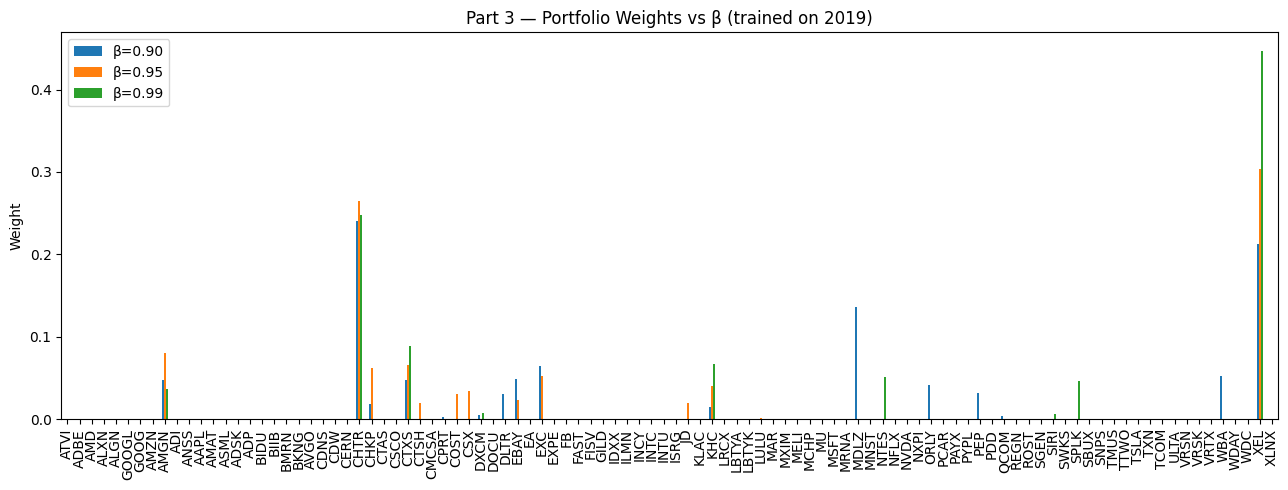

In [12]:
# Part 3: CVaR-minimizing portfolios for beta in {0.90, 0.95, 0.99}

BETA_LIST = [0.90, 0.95, 0.99]
R_TARGET = 0.0002
INDEX_COL = "NDX"

# Robust datetime indexer
def ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    cand_names = {"date","timestamp","time","day","tradingday"}
    date_col = None
    for c in df.columns:
        if c.lower() in cand_names:
            date_col = c
            break
    if date_col is None:
        # fall back: try to parse the FIRST column as dates
        first = df.columns[0]
        try:
            _ = pd.to_datetime(df[first])
            date_col = first
        except Exception:
            raise ValueError(
                "Could not find/parse a date column. "
                f"Available columns: {list(df.columns)}. "
                "Rename your date column to 'Date' or ensure the first column is a parseable date."
            )
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out = out.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
    return out

def returns_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    prices = ensure_datetime_index(prices)
    prices = prices.select_dtypes(include=[np.number])
    return prices.pct_change().dropna(how="any")

def solve_cvar_lp(returns: pd.DataFrame, beta: float, R_target: float):
    Y = returns.values; q, n = Y.shape
    mu = returns.mean(0).values
    N = n + 1 + q
    i_alpha = n; i_u0 = n+1
    c = np.zeros(N); c[i_alpha] = 1.0; c[i_u0:i_u0+q] = 1.0/((1.0-beta)*q)
    bounds = [(0,None)]*n + [(None,None)] + [(0,None)]*q
    A_ub, b_ub = [], []
    for k in range(q):
        row = np.zeros(N); row[:n] = -Y[k,:]; row[i_alpha] = -1.0; row[i_u0+k] = -1.0
        A_ub.append(row); b_ub.append(0.0)
    row = np.zeros(N); row[:n] = -mu; A_ub.append(row); b_ub.append(-R_target)
    A_ub = np.vstack(A_ub); b_ub = np.array(b_ub)
    A_eq = np.zeros((1,N)); A_eq[0,:n] = 1.0; b_eq = np.array([1.0])
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method="highs")
    if not res.success: raise RuntimeError(f"LP failed: {res.message}")
    z = res.x
    return {"x": z[:n], "alpha": z[i_alpha], "objective_cvar": float(c @ z), "status": "optimal", "solver": res}

def empirical_cvar_of_x(returns: pd.DataFrame, x: np.ndarray, beta: float) -> float:
    losses = -(returns.values @ x)
    var = np.quantile(losses, beta, method="higher")
    tail = losses[losses >= var]
    return float(tail.mean()) if tail.size else float(var)

# --- load using your pre-defined path_2019 ---
prices_2019 = pd.read_csv(path_2019)
rets19_all = returns_from_prices(prices_2019)

if INDEX_COL not in rets19_all.columns:
    raise ValueError(f"Expected index column '{INDEX_COL}' in CSV. Got: {list(rets19_all.columns)[:5]}...")

assets = [c for c in rets19_all.columns if c != INDEX_COL]
R19 = rets19_all[assets]

solutions = {}
for beta in BETA_LIST:
    sol = solve_cvar_lp(R19, beta=beta, R_target=R_TARGET)
    sol["empirical_cvar_2019"] = empirical_cvar_of_x(R19, sol["x"], beta)
    solutions[beta] = sol

summary = pd.DataFrame({
    "beta": BETA_LIST,
    "LP_objective_CVaR_2019": [solutions[b]["objective_cvar"] for b in BETA_LIST],
    "Empirical_CVaR_2019":     [solutions[b]["empirical_cvar_2019"] for b in BETA_LIST],
})
display(summary)

weights_df = pd.DataFrame({f"β={b:.2f}": solutions[b]["x"] for b in BETA_LIST}, index=assets)
ax = weights_df.plot(kind="bar", figsize=(13,5))
ax.set_title("Part 3 — Portfolio Weights vs β (trained on 2019)")
ax.set_ylabel("Weight"); ax.legend(); plt.tight_layout(); plt.show()


# Part 4

# Part 4: Conservative min–max monthly CVaR (2019)

_Replace this with your work._

Part 4 — β=0.95, R≥0.000200
Optimal t* (minimized max monthly CVaR, 2019): 0.012446


,weight
XEL,0.450306
CHTR,0.243467
CTXS,0.089679
KHC,0.067274
NTES,0.051131
...,...
VRSK,0.000000
WBA,0.000000
WDAY,0.000000
WDC,0.000000


,CVaR_month
2019-01,0.009288
2019-02,0.012446
2019-03,0.007140
2019-04,0.006637
2019-05,0.010663
2019-06,0.012259
2019-07,0.012446
2019-08,0.012446
2019-09,0.012446
2019-10,0.012078


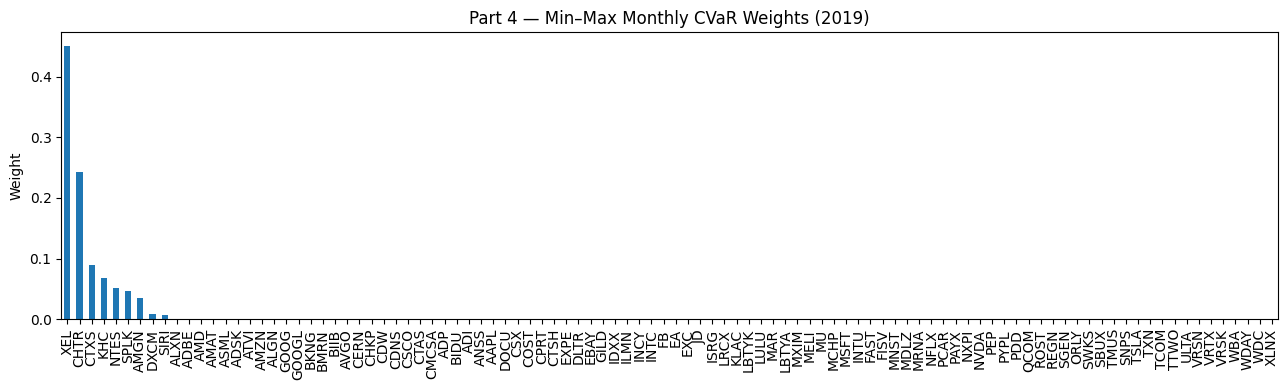

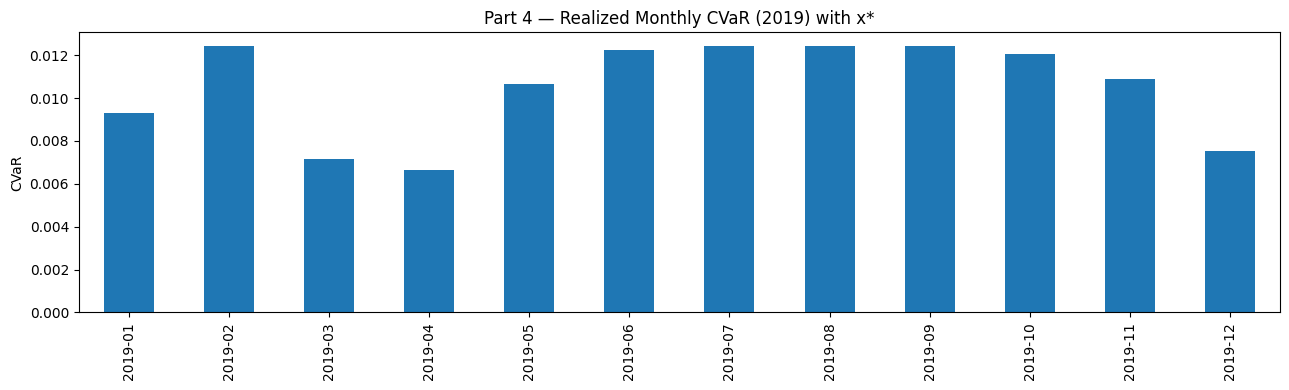

In [13]:
# Part 4: Minimize the maximum monthly CVaR in 2019

BETA = 0.95
R_TARGET = 0.0002
INDEX_COL = "NDX"

# Robust datetime indexer
def ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    cand_names = {"date","timestamp","time","day","tradingday"}
    date_col = None
    for c in df.columns:
        if c.lower() in cand_names:
            date_col = c
            break
    if date_col is None:
        first = df.columns[0]
        try:
            _ = pd.to_datetime(df[first])
            date_col = first
        except Exception:
            raise ValueError(
                "Could not find/parse a date column. "
                f"Available columns: {list(df.columns)}. "
                "Rename your date column to 'Date' or ensure the first column is a parseable date."
            )
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out = out.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
    return out

def returns_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    prices = ensure_datetime_index(prices)
    prices = prices.select_dtypes(include=[np.number])
    return prices.pct_change().dropna(how="any")

def monthly_groups(df: pd.DataFrame):
    out = {}
    for (y,m), g in df.groupby([df.index.year, df.index.month]):
        out[f"{int(y):04d}-{int(m):02d}"] = g
    return dict(sorted(out.items()))

def empirical_cvar(losses: np.ndarray, beta: float) -> float:
    var = np.quantile(losses, beta, method="higher")
    tail = losses[losses >= var]
    return float(tail.mean()) if tail.size else float(var)

# --- load using your pre-defined path_2019 ---
prices_2019 = pd.read_csv(path_2019)

rets19_all = returns_from_prices(prices_2019)
if INDEX_COL not in rets19_all.columns:
    raise ValueError(f"Expected index column '{INDEX_COL}' in CSV. Got: {list(rets19_all.columns)[:5]}...")

assets = [c for c in rets19_all.columns if c != INDEX_COL]
R19 = rets19_all[assets]
mu = R19.mean(0).values
n = R19.shape[1]

groups = monthly_groups(R19)
months = list(groups.keys())
q_per_m = [groups[m].shape[0] for m in months]
M = len(months)

# Decision order: [x(n), t(1), alpha(M), u blocks]
idx_x0, idx_x1 = 0, n
idx_t = idx_x1
idx_alpha0 = idx_t + 1
idx_u0 = idx_alpha0 + M
N = n + 1 + M + sum(q_per_m)

c = np.zeros(N); c[idx_t] = 1.0  # minimize t
bounds = [(0,None)]*n + [(None,None)] + [(None,None)]*M
for qm in q_per_m: bounds += [(0,None)]*qm

A_ub, b_ub = [], []
u_ptr = idx_u0
for mi, m in enumerate(months):
    Ym = groups[m].values; qm = Ym.shape[0]
    for k in range(qm):
        row = np.zeros(N)
        row[idx_x0:idx_x1] = -Ym[k,:]
        row[idx_alpha0+mi] = -1.0
        row[u_ptr+k] = -1.0
        A_ub.append(row); b_ub.append(0.0)
    row = np.zeros(N)
    row[idx_alpha0+mi] = 1.0
    row[u_ptr:u_ptr+qm] = 1.0/((1.0-BETA)*qm)
    row[idx_t] = -1.0
    A_ub.append(row); b_ub.append(0.0)
    u_ptr += qm

row = np.zeros(N); row[idx_x0:idx_x1] = -mu
A_ub.append(row); b_ub.append(-R_TARGET)

A_ub = np.vstack(A_ub); b_ub = np.array(b_ub)
A_eq = np.zeros((1,N)); A_eq[0, idx_x0:idx_x1] = 1.0; b_eq = np.array([1.0])

res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
              bounds=bounds, method="highs")
if not res.success: raise RuntimeError(f"LP failed: {res.message}")

z = res.x
x_opt = z[idx_x0:idx_x1]
t_star = z[idx_t]

per_month_cvar = {}
for m in months:
    losses = -(groups[m].values @ x_opt)
    per_month_cvar[m] = empirical_cvar(losses, BETA)

print(f"Part 4 — β={BETA}, R≥{R_TARGET:.6f}")
print(f"Optimal t* (minimized max monthly CVaR, 2019): {t_star:.6f}")

w = pd.Series(x_opt, index=assets, name="weight").sort_values(ascending=False)
display(w)

pm = pd.Series(per_month_cvar, name="CVaR_month")
display(pm)

ax = w.plot(kind="bar", figsize=(13,4), title="Part 4 — Min–Max Monthly CVaR Weights (2019)")
ax.set_ylabel("Weight"); plt.tight_layout(); plt.show()

ax = pm.plot(kind="bar", figsize=(13,4), title="Part 4 — Realized Monthly CVaR (2019) with x*")
ax.set_ylabel("CVaR"); plt.tight_layout(); plt.show()


# Parts 5–6

## Part 5

### Data organizing

In [14]:
def _parse_index_dates(df: pd.DataFrame) -> pd.DataFrame:
    # look at a sample non-null index value as a string
    sample = next((str(s) for s in df.index if pd.notna(s)), "")
    # crude format sniffing
    if "-" in sample and len(sample.split("-")[0]) == 4:
        fmt = "%Y-%m-%d"    # e.g., 2019-01-02
    elif "/" in sample:
        fmt = "%m/%d/%y"    # e.g., 1/2/20 or 01/02/20
    else:
        # fallback that works with newer pandas; if not supported, let pandas infer
        fmt = "mixed"
    try:
        df.index = pd.to_datetime(df.index, format=fmt)
    except TypeError:
        # older pandas without format="mixed"
        df.index = pd.to_datetime(df.index, errors="coerce")
    df.index.name = "date"  # <-- mimic your "rename first column to 'date'"
    return df

# --- load using your paths and parse dates reliably ---
s19 = pd.read_csv(path_2019, index_col=0)
s19 = _parse_index_dates(s19)

s20 = pd.read_csv(path_2020, index_col=0)
s20 = _parse_index_dates(s20)

# Daily returns (same as your second block)
r19 = s19.pct_change(1).iloc[1:]
r20 = s20.pct_change(1).iloc[1:]

# Drop NDX from both
r19nondx = r19.drop(columns=["NDX"])
r20nondx = r20.drop(columns=["NDX"])

# Keep only common tickers
common_cols = r19nondx.columns.intersection(r20nondx.columns)
r19nondx = r19nondx[common_cols]
r20nondx = r20nondx[common_cols]

# Combined daily returns
r_all = pd.concat([r19nondx, r20nondx], axis=0).sort_index()



### Create a "lookback" function that can handle multiple time windows
#### This creates a dictionary of data frames that are called by "keys" which are the months we're planning for.  This will be a part of the loop gurobi optimizes through later

In [15]:
def make_monthly_lookbacks_calendar(rets: pd.DataFrame, target_year: int = 2020):
    """
    Build rolling lookbacks using actual trading days from `rets`:
      '2020-03' -> first trading day on/after 2019-03-01
       to the
      last trading day before 2020-03-01

      This creates a dictionary of dataFrames
    """
    out = {}
    months = pd.period_range(f'{target_year}-01', f'{target_year}-12', freq='M')

    # convenience: the DatetimeIndex as a numpy array for fast lookups
    idx = rets.index

    for p in months:
        month_start = p.start_time  # e.g., Timestamp('2020-03-01')

        # 1) lb_end = last trading day strictly before the month starts
        #    (assumes you have data covering prior year)
        lb_end = idx[idx < month_start][-1]

        # 2) lb_start_candidate = one year earlier (calendar), then snap to the FIRST trading day
        #    on/after that calendar date so holidays/weekends are respected.
        lb_start_candidate = month_start - pd.DateOffset(years=1)
        # find first index >= lb_start_candidate
        lb_start = idx[idx >= lb_start_candidate][0]

        # 3) slice and drop rows with any missing stocks
        win = rets.loc[lb_start:lb_end].dropna()

        out[p.strftime('%Y-%m')] = win

    return out

lookbacks_2020 = make_monthly_lookbacks_calendar(r_all, target_year=2020)

# sanity check: uncomment to view keys and shape of each data frame
# for m, df in lookbacks_2020.items():
#     print(m, df.index.min().date(), "→", df.index.max().date(), df.shape)


In [16]:
# when you want to set one window, you pick the forward month
# for example, this will return:
# first trading day of march 2019
# to last trading day of feb 2020

# Uncomment to view example
# display(lookbacks_2020['2020-03'].head(2))
# display(lookbacks_2020['2020-03'].tail(2))

### Helper Functions

#### Decision variables: This helps build the decision variables for each rolling window

In [17]:
def init_cvar_decision_vars(window_rets: pd.DataFrame, allow_short: bool = False, quiet: bool = True):
    """
    Build a fresh model for one rolling window.
    Vars:
      x      (N,)  portfolio weights
      alpha         VaR threshold (scalar)
      u      (S,)  tail slacks, one per scenario/day  (MVar)
    """
    # Ensure predictable ordering
    tickers = list(window_rets.columns)
    S, N = window_rets.shape

    # Dense float arrays for Gurobi
    r = window_rets.values.astype(float)            # (S, N)
    mu = window_rets.mean(axis=0).values.astype(float)  # (N,)

    m = gp.Model("cvar_month")
    if quiet:
        m.Params.OutputFlag = 0  # quiet by default

    lb = -GRB.INFINITY if allow_short else 0.0
    ub = GRB.INFINITY  if allow_short else 1.0

    # Decision variables
    x = m.addMVar(N, lb=lb, ub=ub, name="x")            # weights
    alpha = m.addVar(lb=-GRB.INFINITY, name="alpha")    # VaR
    u = m.addMVar(S, lb=0.0, name="u")                  # tail slacks (vector)

    data = {"S": S, "N": N, "tickers": tickers, "r": r, "mu": mu}
    return m, x, alpha, u, data


#### Helps build objectives and constraints for each rolling window

In [18]:
def add_cvar_objective_and_constraints(
    m, x, alpha, u, data,
    beta: float = 0.95,
    R_floor: float | None = 0.0002
):
    """
    Adds:
      - Tail constraints: u + alpha >= losses, where losses = -(r @ x)   (vectorized & Gurobi-safe)
      - Budget: sum(x) = 1
      - Optional return floor: mu @ x >= R_floor
      - Objective: alpha + (1/((1-beta)*S)) * sum(u)
    """
    S = data["S"]
    r = data["r"]   # shape (S, N)
    mu = data["mu"] # shape (N,)

    # Vectorized losses across all scenarios
    losses = - (r @ x)  # length-S MVar

    # Tail constraints (move alpha to LHS to avoid NumPy/Gurobi type issues)
    m.addConstr(u + alpha >= losses, name="tail_all")

    # Budget
    m.addConstr(x.sum() == 1.0, name="budget")

    # Optional expected-return floor
    if R_floor is not None:
        m.addConstr(mu @ x >= R_floor, name="return_floor")

    # Objective (Rockafellar–Uryasev)
    inv_tail_mass = 1.0 / ((1.0 - beta) * S)
    m.setObjective(alpha + inv_tail_mass * u.sum(), GRB.MINIMIZE)


#### Defines losses for each rolling window

##### Note: this is to determine out of sample losses and the NDX evaluation.  It's formulated as a kind of "mini-optimization" problem where the weights will be set (either weights calculated or 1.0 if looking at NDX).  This is done this way to have an apples-to-apples comparison to our in-sample setup

In [19]:
def cvar_lp_on_losses_series(losses: pd.Series, beta: float = 0.95, quiet: bool = True):
    """
    LP-based VaR/CVaR on a *loss* series (losses = -returns).
    Returns (VaR, CVaR) using the Rockafellar–Uryasev formulation.
    """
    L = losses.dropna().to_numpy(dtype=float)
    S = len(L)

    m = gp.Model("cvar_eval_oos")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb=-GRB.INFINITY, name="alpha")
    u = m.addMVar(S, lb=0.0, name="u")

    # Tail constraints (safe form): u + alpha >= L
    m.addConstr(u + alpha >= L, name="tail_all")

    # Objective
    m.setObjective(alpha + (1/((1 - beta) * S)) * u.sum(), GRB.MINIMIZE)

    m.optimize()
    return float(alpha.X), float(m.objVal)


### Full optimization setup: This loop will loop over the dictionary of dataframes and evaluate weights, then determine portfolio performance and benchmark (NDX) performance for those same periods

In [20]:
# === Rolling CVaR loop with LP-based OOS CVaR and NDX summary ===

beta = 0.95
R_floor = 0.0002   # daily 0.02%; set None to remove the ER floor
allow_short = False

months = sorted(lookbacks_2020.keys())      # ['2020-01', ..., '2020-12']
master_tickers = list(r_all.columns)        # stable column order for the weights table

weights_rows, ins_rows, oos_rows = [], [], []

for month_key in months:
    # --- In-sample: optimize on the prior 12-month trading window
    df_win = lookbacks_2020[month_key]
    m, x, alpha, u, data = init_cvar_decision_vars(df_win, allow_short=allow_short)
    add_cvar_objective_and_constraints(m, x, alpha, u, data, beta=beta, R_floor=R_floor)
    m.optimize()

    # Weights aligned to a fixed column order
    w = pd.Series(x.X, index=data["tickers"], name=month_key)
    w = w.reindex(master_tickers).fillna(0.0)
    weights_rows.append(w)

    # In-sample metrics (simple names)
    ins_rows.append({
        "Month": month_key,
        "In_Days": int(df_win.shape[0]),
        "In_VaR": float(alpha.X),
        "In_CVaR": float(m.objVal),  # optimized CVaR objective
        "In_MeanRet": float(df_win.mean() @ w.loc[df_win.columns]),
    })

    # --- Out-of-sample: realized stats in the *target* month (LP CVaR)
    p = pd.Period(month_key, freq='M')
    Rm = r_all.loc[p.start_time:p.end_time][w.index].dropna(how='any')  # realized daily returns in that month
    port_ret = Rm @ w

    losses = -port_ret
    oos_var_lp, oos_cvar_lp = cvar_lp_on_losses_series(losses, beta=beta)

    oos_rows.append({
        "Month": month_key,
        "OOS_Days": int(Rm.shape[0]),
        "OOS_VaR": oos_var_lp,
        "OOS_CVaR": oos_cvar_lp,
        "OOS_MeanRet": float(port_ret.mean()),                # average daily OOS return
        "OOS_CumRet": float((1 + port_ret).prod() - 1),       # monthly total return
    })

# Assemble outputs
weights_df = pd.DataFrame(weights_rows)                 # rows = months, cols = tickers
weights_df.index.name = "Month"

ins_df  = pd.DataFrame(ins_rows).set_index("Month").sort_index()
oos_df  = pd.DataFrame(oos_rows).set_index("Month").sort_index()

# ----- Cumulative CVaR summary (In vs OOS) -----
cvar_summary_df = pd.DataFrame({
    "In_Avg_CVaR":   [ins_df["In_CVaR"].mean()],
    "In_Std_CVaR":   [ins_df["In_CVaR"].std(ddof=1)],
    "In_Max_CVaR":   [ins_df["In_CVaR"].max()],
    "In_Min_CVaR":   [ins_df["In_CVaR"].min()],
    "OOS_Avg_CVaR":  [oos_df["OOS_CVaR"].mean()],
    "OOS_Std_CVaR":  [oos_df["OOS_CVaR"].std(ddof=1)],
    "OOS_Max_CVaR":  [oos_df["OOS_CVaR"].max()],
    "OOS_Min_CVaR":  [oos_df["OOS_CVaR"].min()],
}).T
cvar_summary_df.columns = ["Value"]

# ----- Monthly table: include OOS_MeanRet and show OOS_Total_Return (YTD through each month) -----
# Compute YTD cumulative from monthly OOS total returns
oos_total = (1.0 + oos_df["OOS_CumRet"]).cumprod() - 1.0

monthly_df = (
    ins_df.join(oos_df[["OOS_Days", "OOS_VaR", "OOS_CVaR", "OOS_MeanRet"]], how="left")
          .assign(OOS_Total_Return=oos_total)
          .reindex(months)
)

# Choose columns and order
monthly_df = monthly_df.reindex(columns=[
    "In_Days", "OOS_Days",
    "In_VaR", "OOS_VaR",
    "In_CVaR", "OOS_CVaR",
    "In_MeanRet", "OOS_MeanRet",
    "OOS_Total_Return",
])

# ----- NDX (Nasdaq) summary, LP CVaR on full 2020 -----
ndx_rets_all = pd.concat([r19["NDX"], r20["NDX"]]).sort_index()
ndx_2020 = ndx_rets_all.loc["2020"].dropna()
ndx_losses_2020 = -ndx_2020
ndx_var_lp, ndx_cvar_lp = cvar_lp_on_losses_series(ndx_losses_2020, beta=beta)

ndx_summary_df = pd.DataFrame({
    "NDX_VaR": [ndx_var_lp],
    "NDX_CVaR": [ndx_cvar_lp],
    "NDX_Avg_Daily_Return": [ndx_2020.mean()],
    "NDX_Total_Return": [(1 + ndx_2020).prod() - 1],
}).T
ndx_summary_df.columns = ["NDX_2020"]

# Optional: trimmed weights view (only show weights > 1% abs)
nontrivial_weights_df = (
    weights_df.where(weights_df.abs() > 0.01)
              .dropna(axis=1, how="all")
              .fillna(0.0)
)

# === Displays (reordered with titles) ===
from IPython.display import display

print("\n## In & Out of Sample Portfolio CVaR Results (cumulative)")
display(cvar_summary_df.round(6))

print("\n## In & Out of Sample Portfolio CVaR Results (monthly)")
display(monthly_df.round(6))

print("\n## NDX Performance")
display(ndx_summary_df.round(6))

print("\n## Portfolio Weights")
display(nontrivial_weights_df.round(4))



## In & Out of Sample Portfolio CVaR Results (cumulative)


,Value
In_Avg_CVaR,0.025940
In_Std_CVaR,0.008292
In_Max_CVaR,0.031384
In_Min_CVaR,0.011024
OOS_Avg_CVaR,0.032238
OOS_Std_CVaR,0.023750
OOS_Max_CVaR,0.101232
OOS_Min_CVaR,0.008140



## In & Out of Sample Portfolio CVaR Results (monthly)


,In_Days,OOS_Days,In_VaR,OOS_VaR,In_CVaR,OOS_CVaR,In_MeanRet,OOS_MeanRet,OOS_Total_Return
Month,,,,,,,,,
2020-01,250,20,0.008500,0.008140,0.011090,0.008140,0.001227,0.002266,0.046035
2020-02,250,19,0.008511,0.035750,0.011024,0.035750,0.001061,-0.004170,-0.035214
2020-03,250,22,0.011184,0.074807,0.014841,0.101232,0.000788,-0.000283,-0.067287
2020-04,251,21,0.018740,0.033241,0.029922,0.041765,0.001207,0.007185,0.077170
2020-05,251,20,0.021535,0.029995,0.031384,0.029995,0.001218,0.003404,0.150224
2020-06,249,22,0.019275,0.007950,0.030180,0.026284,0.002216,0.002895,0.224461
2020-07,251,22,0.019360,0.013894,0.030558,0.032245,0.002572,0.002553,0.292167
2020-08,251,21,0.022735,0.014435,0.031039,0.016165,0.002681,0.000772,0.311655
2020-09,250,21,0.017100,0.032770,0.028848,0.034410,0.002280,-0.001446,0.268307



## NDX Performance


,NDX_2020
NDX_VaR,0.039098
NDX_CVaR,0.056495
NDX_Avg_Daily_Return,0.001741
NDX_Total_Return,0.447818



## Portfolio Weights


,AMGN,CERN,CHTR,CHKP,CTXS,CTSH,COST,CSX,DXCM,DOCU,...,INCY,JD,KHC,MAR,MRNA,NTES,ORLY,PDD,TTWO,XEL
Month,,,,,,,,,,,,,,,,,,,,,
2020-01,0.0808,0.0000,0.2650,0.0627,0.0656,0.0196,0.0304,0.0343,0.0000,0.0000,...,0.0000,0.0198,0.0405,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3039
2020-02,0.0858,0.0000,0.2692,0.0654,0.0707,0.0153,0.0113,0.0443,0.0000,0.0000,...,0.0000,0.0304,0.0347,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2982
2020-03,0.0000,0.0000,0.2967,0.0896,0.0000,0.0000,0.0000,0.0000,0.0575,0.0000,...,0.0000,0.0000,0.1112,0.0000,0.0416,0.0000,0.0381,0.0149,0.0000,0.3321
2020-04,0.0000,0.0000,0.0000,0.0000,0.4517,0.0000,0.0000,0.0000,0.0743,0.0000,...,0.0919,0.0000,0.0000,0.1036,0.0498,0.0000,0.0000,0.0739,0.0000,0.0000
2020-05,0.0000,0.0000,0.0000,0.0000,0.2474,0.0000,0.1439,0.0000,0.0272,0.0000,...,0.1154,0.0000,0.0000,0.1132,0.0783,0.0348,0.0000,0.0000,0.0000,0.0000
2020-06,0.0000,0.0000,0.0000,0.0000,0.0515,0.0000,0.1921,0.0000,0.0000,0.0000,...,0.1165,0.0000,0.0000,0.0749,0.1393,0.1366,0.0000,0.0761,0.0000,0.0000
2020-07,0.0000,0.0000,0.0000,0.0000,0.0506,0.0000,0.2179,0.0000,0.0000,0.0000,...,0.1391,0.0000,0.0000,0.0000,0.1395,0.1271,0.0000,0.1082,0.0000,0.0000
2020-08,0.0000,0.0840,0.0000,0.0000,0.0000,0.0000,0.3483,0.0000,0.0000,0.0000,...,0.1347,0.0000,0.0000,0.0000,0.1322,0.1064,0.0000,0.1180,0.0000,0.0000
2020-09,0.0000,0.1167,0.0000,0.0000,0.0000,0.0000,0.0583,0.0000,0.0000,0.1258,...,0.1308,0.0000,0.0000,0.0000,0.0696,0.0000,0.0000,0.0582,0.0293,0.0000


### Heatmap over 2020 of "non-trivial" weights, defined as > 1% of the portfolio at any one time

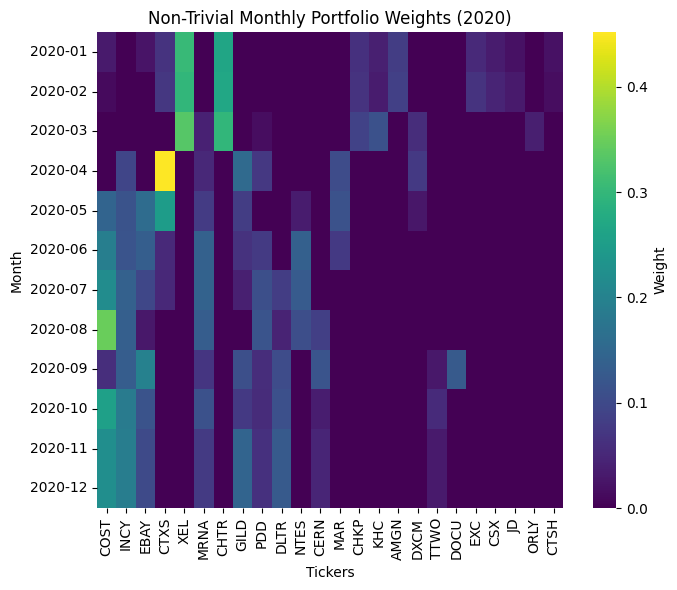

In [21]:
# === Heatmap of weights (months × tickers) ===

# Pick which weights table to visualize:
W = nontrivial_weights_df.copy()   # or weights_df if you want *all* columns

# Optional: sort tickers by average weight across 2020 for a cleaner view
col_order = W.mean(axis=0).sort_values(ascending=False).index
W = W[col_order]

plt.figure(figsize=(min(24, 1 + 0.25*W.shape[1]), 6))  # adjust width dynamically
ax = sns.heatmap(
    W,
    cmap="viridis",
    linewidths=0.0,
    cbar_kws={"label": "Weight"},
    annot=False
)
ax.set_title("Non-Trivial Monthly Portfolio Weights (2020)")
ax.set_xlabel("Tickers")
ax.set_ylabel("Month")
plt.tight_layout()
plt.show()


### Part 5 evaluation:  Using this method, there is some reduction in average out-of-sample CVaR (down to 3.2% from 4.6%), but given the nature of 2020 in hindsight, it's clear there was much more volatility in the market that we can't necessarily fully control for in this model (as shown in min/max comparisons for in and out-of-sample CVaR).  

### Also, our portfolio performed well (45.1% return), the NDX index 44.8% over that same time, so in terms of returns, it could be that most of that performance is intrinsic to the market, not to the extra effort we're going to.  Additional factors like trading fees and short-term capital gains taxes would have to be factored in to see if it's worth it from that perspective.  

### It would also be useful to back test this method on years the market was down to see if losses were controlled during those years

## Part 6

### Mask for months that have > 5% change in weight for any one instrument (9 out of 12 months)

In [22]:
# Absolute change in weights month to month
weight_changes = weights_df.diff().abs()

# Flag any changes > 0.05
unstable_flags = (weight_changes > 0.05)

# Which months have at least one instrument unstable?
unstable_months = unstable_flags.any(axis=1)

# uncomment to see all weight changes
# display(weight_changes.round(4))

display(unstable_months)


,0
Month,
2020-01,False
2020-02,False
2020-03,True
2020-04,True
2020-05,True
2020-06,True
2020-07,True
2020-08,True
2020-09,True


### Specific instruments that changed > 5% during those months

In [23]:
breaches = (weights_df.diff().abs() > 0.05)
violators_by_month = {
    m: list(row[row].index) for m, row in breaches.iterrows() if row.any()
}
pd.Series(violators_by_month, name="Tickers > 5% change")


,Tickers > 5% change
2020-03,"[AMGN, CTXS, DXCM, EXC, KHC]"
2020-04,"[CHTR, CHKP, CTXS, GILD, INCY, KHC, MAR, PDD, ..."
2020-05,"[CTXS, COST, EBAY, GILD, PDD]"
2020-06,"[CTXS, MRNA, NTES, PDD]"
2020-07,"[DLTR, MAR]"
2020-08,"[CERN, CTXS, COST, EBAY]"
2020-09,"[COST, DOCU, DLTR, EBAY, GILD, MRNA, NTES, PDD]"
2020-10,"[CERN, COST, DOCU, EBAY, INCY]"
2020-11,[GILD]


### Part 6 evaluation:  There's really only a few levers to pull on to keep stock weights from adjusting more than 5% in any given month.
1. Add that % change as a constraint.  This is probably the only way to guarantee no such change occurs.
2. You could induce a turnover penalty or a kind of turnover budget for the entire portfolio, but these are kind of "softer" controls.
3. Other factors such as risk appetite (beta), return floor, or the frequency of rebalance may indirectly affect turnover, but there's no assurance of that.
4. Setting strict weight limits is possible, but again, not a sure-thing.
5. Allowing shorts or applying leverage (weights > 1.0) are also unlikely to make the portfolio more stable.

### For all of these things, it's not clear without running simulations whether that would improve CVaR and returns performance, or simply add artificial limitations